In [1]:
# Steepest descent and Newton line-search methods applied to LJ7 cluster in 3D 
import numpy as np
import matplotlib.pyplot as plt
from LJhelpers import *

In [2]:
# Set up the initial configuration

# Four lical minima of LJ7:
# f1 = -16.50538417 Pentagonal bipyramid 
# f2 = -15.93504306 Capped octahedron 
# f3 = -15.59321094 Tricapped tetrahedron 
# f4 = -15.53306005 Bicapped trigonal bipyramid

# Options: model = 0,1,2,3, or 4.
# Model 0 corresponds to a random initialization.
# Models 1--4 set the system up close to the corresponding local minima
# listed above.


In [3]:
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for backtracking line search
c = 0.1;
rho = 0.9;


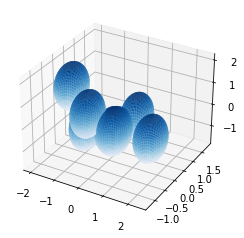

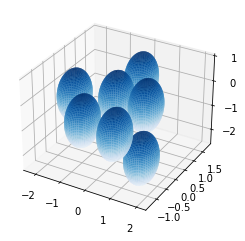

LJpot =  -7.725258746375025


In [4]:
model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x = remove_rotations_translations(xyz)
drawconf(LJvector2array(x),0.5*rstar)
print("LJpot = ",LJpot(x))
# print(LJhess(x))

Initially, f =  -7.725258746375025 , ||grad f|| =  7.973032265349599
iter 1: dir = SD, f = -8.388272, ||grad f|| = 1.673024e+01, step length = 3.138e-01
iter 2: dir = SD, f = -8.799702, ||grad f|| = 7.038528e+00, step length = 1.853e-01
iter 3: dir = SD, f = -8.904658, ||grad f|| = 9.915722e+00, step length = 1.216e-01
iter 4: dir = SD, f = -9.024315, ||grad f|| = 8.332843e+00, step length = 9.848e-02
iter 5: dir = SD, f = -9.106441, ||grad f|| = 6.618891e+00, step length = 7.977e-02
iter 6: dir = SD, f = -9.186786, ||grad f|| = 5.372602e+00, step length = 6.461e-02
iter 7: dir = SD, f = -9.220333, ||grad f|| = 5.820672e+00, step length = 5.815e-02
iter 8: dir = SD, f = -9.276787, ||grad f|| = 4.917195e+00, step length = 5.233e-02
iter 9: dir = SD, f = -9.313924, ||grad f|| = 4.884161e+00, step length = 4.710e-02
iter 10: dir = SD, f = -9.344948, ||grad f|| = 5.189604e+00, step length = 4.710e-02
iter 11: dir = SD, f = -9.380539, ||grad f|| = 5.143692e+00, step length = 4.710e-02
iter 

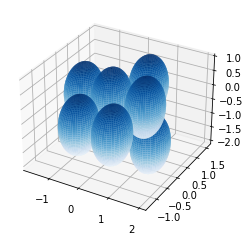

iter 101: dir = SD, f = -11.755253, ||grad f|| = 1.312932e+00, step length = 1.330e-02
iter 102: dir = SD, f = -11.758369, ||grad f|| = 1.312998e+00, step length = 1.330e-02
iter 103: dir = SD, f = -11.761655, ||grad f|| = 1.310771e+00, step length = 1.330e-02
iter 104: dir = SD, f = -11.763601, ||grad f|| = 1.548516e+00, step length = 1.478e-02
iter 105: dir = SD, f = -11.766309, ||grad f|| = 1.663277e+00, step length = 1.642e-02
iter 106: dir = SD, f = -11.770439, ||grad f|| = 1.570270e+00, step length = 1.642e-02
iter 107: dir = SD, f = -11.773766, ||grad f|| = 1.634220e+00, step length = 1.642e-02
iter 108: dir = SD, f = -11.777823, ||grad f|| = 1.585079e+00, step length = 1.642e-02
iter 109: dir = SD, f = -11.781616, ||grad f|| = 1.616048e+00, step length = 1.642e-02
iter 110: dir = SD, f = -11.785769, ||grad f|| = 1.591320e+00, step length = 1.642e-02
iter 111: dir = SD, f = -11.789948, ||grad f|| = 1.604682e+00, step length = 1.642e-02
iter 112: dir = SD, f = -11.794307, ||grad 

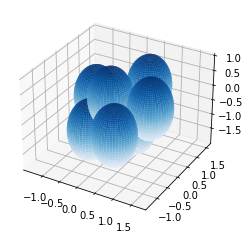

iter 201: dir = SD, f = -15.218042, ||grad f|| = 5.354771e+00, step length = 5.815e-02
iter 202: dir = SD, f = -15.271294, ||grad f|| = 7.978303e+00, step length = 6.461e-02
iter 203: dir = SD, f = -15.341072, ||grad f|| = 5.936935e+00, step length = 6.461e-02
iter 204: dir = SD, f = -15.421998, ||grad f|| = 8.749601e+00, step length = 7.179e-02
iter 205: dir = SD, f = -15.503508, ||grad f|| = 6.570295e+00, step length = 7.179e-02
iter 206: dir = SD, f = -15.615669, ||grad f|| = 9.544666e+00, step length = 7.977e-02
iter 207: dir = SD, f = -15.697878, ||grad f|| = 7.142717e+00, step length = 7.977e-02
iter 208: dir = SD, f = -15.811495, ||grad f|| = 1.064215e+01, step length = 8.863e-02
iter 209: dir = SD, f = -15.917985, ||grad f|| = 6.776981e+00, step length = 7.977e-02
iter 210: dir = Newton, f = -16.050189, ||grad f|| = 1.473283e+01, step length = 3.487e-01
iter 211: dir = Newton, f = -16.358935, ||grad f|| = 5.194746e+00, step length = 1.000e+00
iter 212: dir = Newton, f = -16.498

In [5]:
# start minimization
# choose algorithm
# direction = 0: steepest descent
# direction = 1: Newton
direction = 1

f = LJpot(x)
g = LJgrad(x)
norm_g = np.linalg.norm(g)
print("Initially, f = ",f,", ||grad f|| = ",norm_g)

fvals = np.zeros(iter_max)
fvals[0] = f
ngvals = np.zeros(iter_max)
ngvals[0] = norm_g

iter = 1

while (norm_g > tol and iter < iter_max): 
    #choose search direction
    if( direction == 0): # steepest descent
        p = -g
        dir = "SD"
    elif( direction == 1): # Newton
        H = LJhess(x)
        p = np.linalg.solve(H,-g) 
        # if( np.dot(g,p) < 0 ): # descent direction
            # dir = "Newton"            
#         print(np.linalg.eigvals(H))
        spd = np.all(np.linalg.eigvals(H) > 0)
        if( spd ): # H is SPD, use Newton's direction
            p = np.linalg.solve(H,-g) 
            dir = "Newton"
        else: # use the steepest descent direction
            p = -g
            dir = "SD";
    else:
        print("direction is out of range")
        break
    # normalize the search direction if its length greater than 1
    norm_p = np.linalg.norm(p)
    if( norm_p > 1):
        p = p/norm_p
    # do backtracking line search along the direction p
    a = 1 # initial step length
    f_temp = LJpot(x + a*p)
    cpg = c*np.dot(p,g)
#     print("cpg = ",cpg,"f = ",f,"f_temp = ",f_temp)
    while( f_temp > f + a*cpg ): # check Wolfe's condition 1
        a = a*rho
        if( a < 1e-14 ):
            print("line search failed\n");
            iter = iter_max-1
            break
        f_temp = LJpot(x + a*p)        
#         print("f_temp = ",f_temp)
    x = x + a*p
    f = LJpot(x)
    g = LJgrad(x)
    norm_g = np.linalg.norm(g)
#     print("iter ",iter,": dir = ",dir,", f = ",f,", ||grad f|| = ",norm_g,", step length = ",a)
    print(f"iter {iter}: dir = {dir}, f = {f:.6f}, ||grad f|| = {norm_g:.6e}, step length = {a:.3e}")
    if( iter%100 == 0 ):
        # restore all coordinates
        xyz = LJvector2array(x)
        drawconf(xyz,0.5*rstar)
    fvals[iter] = f
    ngvals[iter] = norm_g
    iter = iter + 1
print(f"Result: f = {f:.10f}, ||grad f|| = {norm_g:.6e}")
    

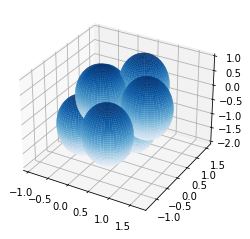

In [6]:
# visualize the final configuration and plot graphs
xyz = LJvector2array(x)    
drawconf(xyz,0.5*rstar)

Text(0, 0.5, 'Function values')

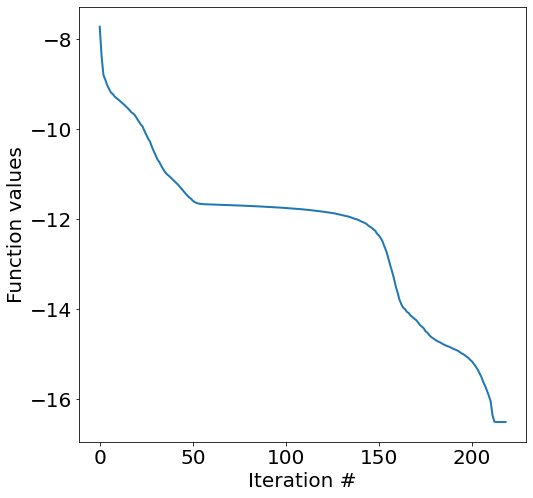

In [7]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
plt.plot(np.arange(iter),fvals[0:iter],linewidth = 2)
plt.xlabel("Iteration #")
plt.ylabel("Function values")

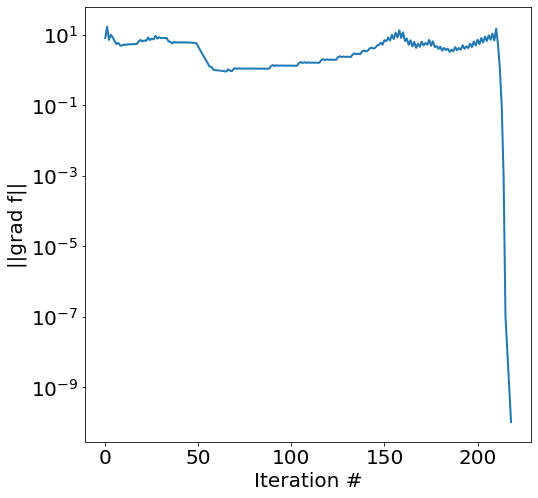

In [8]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(8,8))
plt.plot(np.arange(iter),ngvals[0:iter],linewidth = 2)
plt.xlabel("Iteration #")
plt.ylabel("||grad f||")
plt.yscale("log")

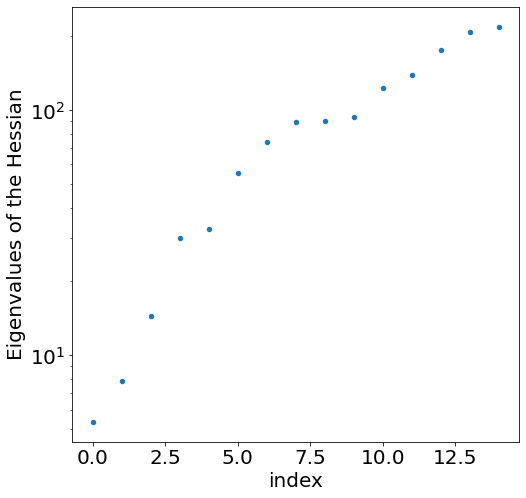

In [9]:
plt.rcParams.update({'font.size': 20})
H = LJhess(x)
evals = np.sort(np.linalg.eigvals(H))
plt.figure(figsize=(8,8))
plt.scatter(np.arange(np.size(x)),evals,s = 20)
plt.xlabel("index")
plt.ylabel("Eigenvalues of the Hessian")
if( evals[0] > 0 ):
    plt.yscale("log")
